In [1]:
import pandas as pd
import re, string
from collections import Counter, OrderedDict
from spacy.lang.en.stop_words import STOP_WORDS
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import numpy as np
from PIL import Image
from contractions import CONTRACTION_MAP
import pdb

In [2]:
df = pd.read_csv("raw_data/train.zip", 
                 error_bad_lines=False)

b'Skipping line 8836: expected 4 fields, saw 5\n'
b'Skipping line 535882: expected 4 fields, saw 7\n'


In [3]:
df.head()

,ItemID,Sentiment,SentimentSource,SentimentText
0,1,0,Sentiment140,is so sad for my APL frie...
1,2,0,Sentiment140,I missed the New Moon trail...
2,3,1,Sentiment140,omg its already 7:30 :O
3,4,0,Sentiment140,.. Omgaga. Im sooo im gunna CRy. I'...
4,5,0,Sentiment140,i think mi bf is cheating on me!!! ...


# Cleanup the texts

At first we need to clean the text dataset.

We will remove urls, html links, punctuation and emojis. 

Then we will expand the contractions, like don't to do not, haven't to have not etc.

In [4]:
def expand_contractions(text):
    contractions_pattern = re.compile('({})'.format('|'.join(CONTRACTION_MAP.keys())), 
                                      flags=re.IGNORECASE)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = CONTRACTION_MAP.get(match)\
                            if CONTRACTION_MAP.get(match)\
                            else CONTRACTION_MAP.get(match.lower())
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text;

def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)


def remove_html(text):
    html = re.compile(r'<.*?>')
    return html.sub(r'', text)


def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)


def remove_emoji(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [5]:
def cleanup_text(line: str) -> str:
    """
    Args:
        line: text line of the opinion
    Returns:
        text line where not alphabetical characters removed
    """
    corrections = {"&quot": "", "&amp": ""}
    line_lower = expand_contractions(line.lower())
    
    for wrong, cor in corrections.items():
        line_lower = line_lower.replace(wrong, cor)
    
    # remove html
    line_lower = remove_html(line_lower)
    
    # remove url
    line_lower = remove_url(line_lower)
    
    # remove emoji
    line_lower = remove_emoji(line_lower)
    #words = re.findall(r"[\w']+", line_lower)

    return remove_punct(line_lower)

In [6]:
df["SentimentText"] = df["SentimentText"].apply(cleanup_text)

In [7]:
positives = df[df['Sentiment']==1].copy()
negatives = df[df['Sentiment']==0].copy()

# Analyze dataset

In [8]:
def create_vocabulary(texts):    
    counter = Counter()
    for line in texts:
        counter.update([x for x in line.split(" ") if x not in STOP_WORDS and len(x) > 1])
    return counter

In [9]:
pos_vocabulary = create_vocabulary(positives["SentimentText"])
neg_vocabulary = create_vocabulary(negatives["SentimentText"])

---------------------------------------

**The next step is to find the top 10 most frequent words in positive and negative sentiment tweets.**

**To achive this, we can just select the top 10 words from positive and negative vocabularies, that we have created.**

**But that way some common words that are both in positive and negative words will also be shown.**

**To see more clear representation, top 100 words from both positive and negative vocabularies are selected. Then words that occur in both groups are removed. From the rest of the words top 10 words are selected from both vocabularies**



--------------------

In [10]:
# select first 100 words from positive and negative vocabularies.

pv = list(pos_vocabulary.most_common(100))
nv = list(neg_vocabulary.most_common(100))

# select words in positive and negative first 100 vocabularies
word_nv = set([x[0] for x in nv])
word_pv = set([x[0] for x in pv])

# select word, frequency pairs from positive vocabulary not occuring 
# in negative vocab and vice versa

pv = [x for x in pv if x[0] not in word_nv]
nv = [x for x in nv if x[0] not in word_pv]

In [11]:
positive_cloud = WordCloud(background_color="white",
                           max_words=10,relative_scaling=0.5,
                           normalize_plurals=False).generate_from_frequencies(dict(pv))


In [12]:
negative_cloud = WordCloud(background_color="white", 
                           max_words=10,relative_scaling=0.5,
                           normalize_plurals=False).generate_from_frequencies(dict(nv))


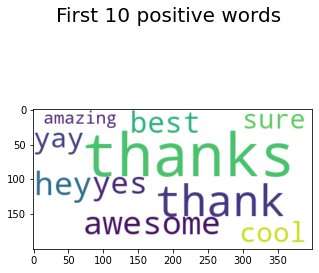

In [13]:
plt.figure(figsize=[5,5], )
plt.suptitle("First 10 positive words", fontsize=20)
plt.imshow(positive_cloud, interpolation="bilinear")

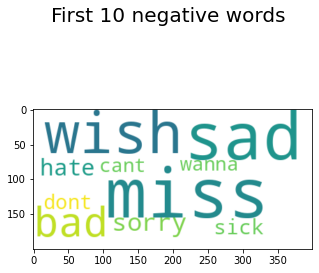

In [14]:
plt.figure(figsize=[5,5], )
plt.suptitle("First 10 negative words", fontsize=20)
plt.imshow(negative_cloud, interpolation="bilinear")

/home/haziyevv/ENVS/interviewproject/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/haziyevv/ENVS/interviewproject/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Frequencies')

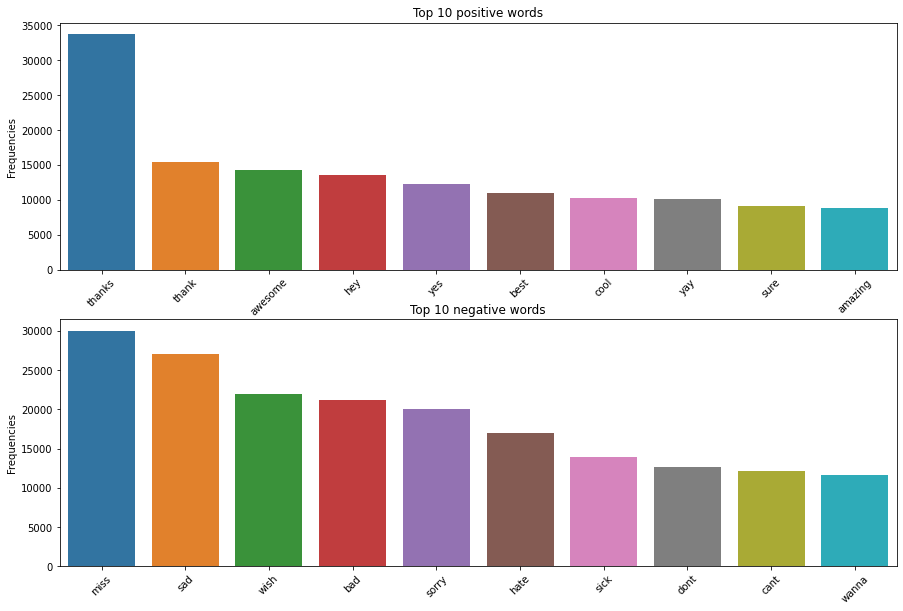

In [15]:
fix, axe = plt.subplots(2, 1, figsize=(15, 10))
pxs = [x[0] for x in pv[:10]]
pys = [x[1] for x in pv[:10]]
nxs = [x[0] for x in nv[:10]]
nys = [x[1] for x in nv[:10]]
sns.barplot(pxs, pys, ax=axe[0])
for tick in axe[0].get_xticklabels():
    tick.set_rotation(45)

sns.barplot(nxs, nys, ax=axe[1])
for tick in axe[1].get_xticklabels():
    tick.set_rotation(45)

axe[0].set_title("Top 10 positive words")
axe[0].set_ylabel("Frequencies")

axe[1].set_title("Top 10 negative words")
axe[1].set_ylabel("Frequencies")

# Zipfs Law

In [16]:
vocabulary = create_vocabulary(df["SentimentText"])

In [17]:
sorted_vocab = list(vocabulary.most_common(len(vocabulary)))

**Three different ways to plot are used to show the distribution of the words.**


**First, 100 highest frequency words are selected and a scatter plot is drawn**

**Second, log probabilities are drawn**

**Third, Cumulative frequencies are drawn**

Text(0, 0.5, 'cumulative frequency')

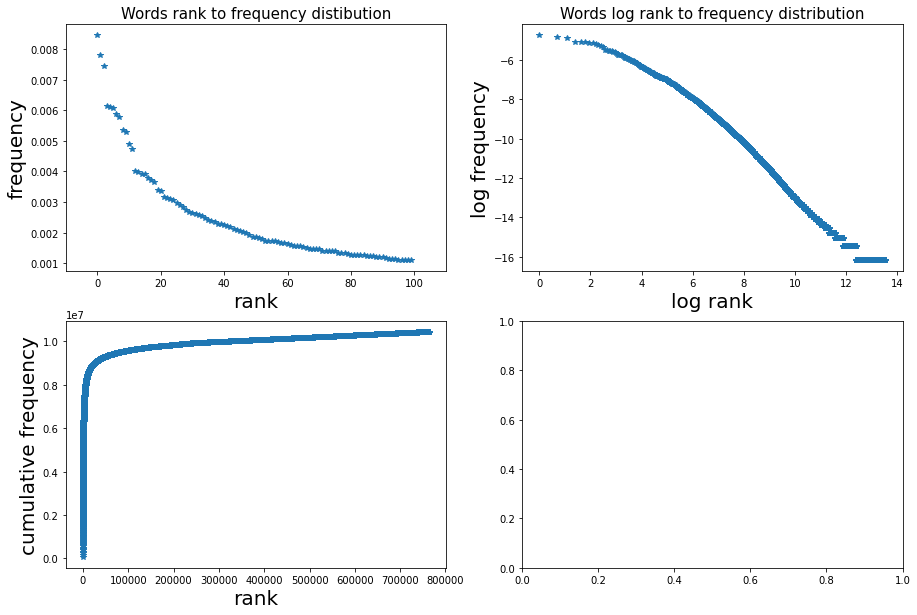

In [18]:
fig, axe = plt.subplots(2, 2, figsize=(15, 10))
xs = [x[0] for x in sorted_vocab]
ys = [x[1] for x in sorted_vocab]
total_words = sum(ys)
word_probabilities = [x/total_words for x in ys]

axe[0,0].plot([x for x in range(100)], [x for x in word_probabilities[:100]], "*")
axe[0,0].set_xlabel(xlabel='rank', size=20)
axe[0,0].set_ylabel(ylabel='frequency', size=20)
axe[0,0].set_xlim(-10,110)
axe[0,0].set_title("Words rank to frequency distibution", fontsize=15)

axe[0,1].plot([np.log(x+1) for x in range(len(xs))], [np.log(x) for x in word_probabilities], "*")
axe[0,1].set_xlabel(xlabel='log rank', size=20)
axe[0,1].set_ylabel(ylabel='log frequency', size=20)
axe[0,1].set_title("Words log rank to frequency distribution", fontsize=15)

prob_cumsum = np.cumsum(ys)
axe[1,0].plot([x for x in range(len(xs))], prob_cumsum, "*")
axe[1,0].set_xlabel(xlabel='rank', size=20)
axe[1,0].set_ylabel(ylabel='cumulative frequency', size=20)


In each plot we can see that only small portion of the words take most frequency.  

#  Sentiment Analysis model

**I will use pytorch and its torchtext module to make the model**

In [19]:
import random, os
import torch
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
import torchtext
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.optim as optim
from torchtext.vocab import Vocab
from argparse import Namespace

In [20]:
device = "cuda" if torch.cuda.is_available else "cpu"

args = Namespace(
    tweet_vocabulary="ckpt/vocabulary",
    hidden_dim=256,
    learning_rate=0.001,
    train_csv="raw_data/train.zip",
    batch_size=128,
    num_epochs=5,
    num_layers=2,
    embedding_size=100,
    dropout=0.3,
    output_dim=1
)

torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

In [21]:
labels = df['Sentiment']
texts = df['SentimentText']

X_train, X_val, y_train, y_val = train_test_split(texts, labels, test_size=0.1)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.05)

In [22]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, embedding_size, hidden_dim,
                 output_dim, padding_id, n_layers, dropout, pretrained_embeddings=None):
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings=input_dim,
                                      embedding_dim=embedding_size,
                                      padding_idx=padding_id)

        self.rnn = nn.LSTM(embedding_size,
                           hidden_dim,
                           num_layers=n_layers,
                           bidirectional=True,
                           dropout=dropout)

        self.fc = nn.Linear(hidden_dim*2, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text, text_lengths):
        embedded = self.embedding(text)
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.to('cpu'))
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)

        hidden = self.dropout(torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1))
        out = self.fc(hidden)
        return out.squeeze(1)

In [23]:
# To convert sentences to tokenized and encoded form

def text_transform(text, Vocabulary):
    return [Vocabulary['<BOS>']] + [Vocabulary[token]
                                    for token in text.split(" ")] + [Vocabulary['<EOS>']]


In [24]:
def collate_batch(batch):
    batch.sort(key=lambda x: len(x[0]), reverse=True)
    label_list, text_list, text_lengths = [], [], []
    for _text, _label in batch:
        label_list.append(_label)
        processed_text = torch.tensor(_text)
        text_list.append(processed_text)
        text_lengths.append(len(processed_text))
    return torch.tensor(label_list, dtype=torch.float32), pad_sequence(text_list, padding_value=3.0), torch.tensor(text_lengths, dtype=torch.int64, device="cpu")

In [25]:
def calculate_accuracy(y_pred, y):
    y = y.detach().numpy()
    y_pred = torch.sigmoid(y_pred).detach().numpy()
    y_pred[y_pred > 0.5] = 1
    y_pred[y_pred < 0.5] = 0
    correct = len(y_pred[y_pred == y])
    return (correct/y_pred.shape[0]) * 100

In [26]:
TweetVocabulary = torch.load(args.tweet_vocabulary)

In [27]:
# Build the dataset and dataloader

train_dataset = [(text_transform(text, TweetVocabulary), label)
                     for (text, label) in zip(X_train, y_train)]

val_dataset = [(text_transform(text, TweetVocabulary), label)
                    for (text, label) in zip(X_val, y_val)]

test_dataset = [(text_transform(text, TweetVocabulary), label)
                    for (text, label) in zip(X_test, y_test)]

In [28]:
lstm_model = LSTMModel(input_dim=len(TweetVocabulary), embedding_size=args.embedding_size,
                      hidden_dim=args.hidden_dim, output_dim=1, padding_id=3,
                      n_layers=args.num_layers, dropout=args.dropout)


lstm_model.load_state_dict(torch.load(os.path.join("ckpt", "model_lstm.pt")))
lstm_model = lstm_model.to(device)

In [29]:
optimizer = optim.Adam(params=lstm_model.parameters(), lr=args.learning_rate)
loss_fn = nn.BCEWithLogitsLoss().to(device)

In [30]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=args.batch_size,
                          shuffle=True,
                          collate_fn=collate_batch)

val_loader = DataLoader(dataset=val_dataset,
                        batch_size=args.batch_size,
                        shuffle=True,
                        collate_fn=collate_batch)

test_loader = DataLoader(dataset=test_dataset,
                        batch_size=1,
                        shuffle=True,
                        collate_fn=collate_batch)

In [31]:
lstm_model = lstm_model.eval()
total_accuracy = []
total_loss = 0.0

with torch.no_grad():
    for ys, xs, text_lengths in test_loader:
        xs = xs.to(device)
        ys = ys.to(device)
        predicted = lstm_model(xs, text_lengths)
        loss = loss_fn(predicted, ys)

        total_loss += loss.item()
        accuracy = calculate_accuracy(predicted.cpu(), ys.cpu())
        total_accuracy.append(accuracy)
        
print(f"Test loss: {total_loss}")
print(f"Test accuracy: {sum(total_accuracy)/len(total_accuracy)}")

Test loss: 4010.9216319813795
Test accuracy: 78.71801368127691


# About the LSTM method applied

At first I have applied the one layer lstm model. I take the sentences as batch and tokenize them and pad them to the max length sentence in the batch. Then input them to the embedding layer, where each token is converted to an embedding vector. The I input those embedding vectors to the lstm layer. I have used a bidirectional LSTM model, which will take into account both left in the sequence and right in the sequence to the token. I take the both forward and backward information to the last dimension, and concatenate them. The concatenated vector is fed to a linear feed fully connected layer. I do not apply softmax, because the loss function does that for me.  

--------------

**Building the models with Bert**

**About the BERT methods applied**

After finding 78 % validation accuracy with a bidirection lstm model, we have other choices too. One is start training with a pretrained model. This should improve the results. But I chosed bert for this in a similar way. Instead of embedding layer, I give inputs to bert model and it returns a contextual word embedding vector, which is a better method compared to a embedding model that is not aware of the context.  With this model, I have achieved around 84% validation accuracy.

Finally I have fine tuned the BERT model for this task, which gave the higest result of 86 % accuracy. 

--------------------

In [32]:
from transformers import BertTokenizer, BertModel, BertTokenizer

In [33]:
    
class BERTLSTMModel(nn.Module):
    def __init__(self, bert, hidden_dim, 
                 output_dim, n_layers, dropout):
        super().__init__()
        self.bert = bert
        embedding_dim = bert.config.to_dict()['hidden_size']
        self.rnn = nn.LSTM(embedding_dim,
                   hidden_dim,
                   num_layers=n_layers,
                   bidirectional=True,
                   dropout=0 if n_layers < 2 else dropout,
                   batch_first=True)

        self.fc = nn.Linear(2*hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, texts, attention_mask):
        with torch.no_grad():
            embedded = self.bert(
                texts,
                attention_mask
            )[0]
        self.rnn.flatten_parameters()
        output, (hidden, cell) = self.rnn(embedded)
        output = self.dropout(torch.cat((hidden[-2, :, :], 
                                         hidden[-1, :, :]), 
                                         dim=1))
        out = self.fc(output)
        return out.squeeze(1)

    
class BERTModel(nn.Module):
    def __init__(self, bert, output_dim, dropout=0.3):
        super().__init__()
        self.bert = bert
        embedding_dim = bert.config.to_dict()['hidden_size']
        self.fc = nn.Linear(embedding_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
    def forward(self, input_ids, attention_mask):
        pooled_out = self.bert(input_ids, attention_mask)
        out = self.dropout(pooled_out[1])
        out = self.fc(out)
        return out.squeeze(1)

In [34]:
class SentimentDataset(Dataset):
    def __init__(self, tweets, labels, tokenizer, max_len):
        self.tweets = tweets
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.tweets)

    def __getitem__(self, idx):
        tweet = self.tweets[idx]
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            tweet,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding="max_length",
            return_attention_mask=True,
            truncation=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.float32)
        }

In [35]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
max_input_length = 128

In [36]:
train_dataset = SentimentDataset(X_train.to_list(), y_train.to_list(), tokenizer, max_input_length)
val_dataset = SentimentDataset(X_val.to_list(), y_val.to_list(), tokenizer, max_input_length)
test_dataset = SentimentDataset(X_test.to_list(), y_test.to_list(), tokenizer, max_input_length)

In [37]:
train_data_loader = DataLoader(train_dataset,
                               batch_size=4,
                               shuffle=True,
                               num_workers=8)

val_data_loader = DataLoader(val_dataset,
                             batch_size=4,
                             shuffle=True,
                             num_workers=8)

test_data_loader = DataLoader(test_dataset,
                             batch_size=1,
                             shuffle=False,
                             num_workers=1)

In [38]:
bert = BertModel.from_pretrained('bert-base-uncased')


bert_lstm_model = BERTLSTMModel(bert=bert,
                      hidden_dim=args.hidden_dim,
                      output_dim=args.output_dim,
                      n_layers=1,
                      dropout=0.5)

optimizer = optim.Adam(bert_lstm_model.parameters(),
                       lr=args.learning_rate)


loss_fn = nn.BCEWithLogitsLoss().to(device)
state_dict = torch.load("ckpt/model_lstm_bert.pt", map_location=device)
new_state_dict = OrderedDict()
for k,v in state_dict.items():
    name = k[7:]
    new_state_dict[name] = v

bert_lstm_model.load_state_dict(new_state_dict)
bert_lstm_model = bert_lstm_model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [39]:
def eval_model(epoch, model, val_data_loader):
    total_eval_loss = 0.0
    total_val_accuracy = []
    model = model.eval()
    
    with torch.no_grad():
        for data in val_data_loader:
            xs = data["input_ids"].to(device)
            ys = data["labels"].to(device)
            attention_mask = data["attention_mask"].to(device)
            predicted = model(xs, attention_mask)
            val_loss = loss_fn(predicted, ys)

            total_eval_loss += val_loss.item()
            accuracy = calculate_accuracy(predicted.cpu(), ys.cpu())
            total_val_accuracy.append(accuracy)
    print(f"Epoch {epoch}, Validation loss: {total_eval_loss}")
    print(f"Epoch {epoch}, Validation accuracy: {sum(total_val_accuracy)/len(total_val_accuracy)}")


In [40]:
eval_model(1, bert_lstm_model, test_data_loader)

Epoch 1, Validation loss: 2834.064402458811
Epoch 1, Validation accuracy: 84.21586014694705


In [41]:
bert_model = BERTModel(bert=bert,
                      output_dim=args.output_dim,
                      dropout=args.dropout)

state_dict = torch.load("ckpt/model_only_bert.pt", map_location=device)
new_state_dict = OrderedDict()
for k,v in state_dict.items():
    name = k[7:]
    new_state_dict[name] = v

bert_model.load_state_dict(new_state_dict)
bert_model = bert_model.to(device)

In [42]:
eval_model(1, bert_model, test_data_loader)

Epoch 1, Validation loss: 2730.8539856094867
Epoch 1, Validation accuracy: 86.43273372181403
